AO3 analysis: basic demographics
==================

This notebook presents the code used to generate the plots in [post 1]() of [my series on Archive of Our Own metadata]().  The underlying database is not, and will not be, public, but the code here can be reused by others with similar plotting needs.

This particular post discusses the distribution of works in time, language, rating, word count, chapter count, completeness, and whether or not they are in a series, plus distributions of reader engagement metrics like kudos and comments.

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter

from ao3db import ao3db
from utils import renorm_kde_plot, rescale_axis, add_log_axis_labels

In [2]:
# Some settings that will help us make pretty plots
sns.set(style='whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
figsize = plt.gcf().get_size_inches()
cmap = plt.get_cmap("viridis")
single_color = sns.color_palette('dark')[2]

<Figure size 864x576 with 0 Axes>

In [3]:
db = ao3db()

First, get total numbers of words & hits and total number of works.

In [4]:
data = db.get_data('Hits', 'Words').replace('', 0)
print("{} hits and {} words from  {} total works".format(
    int(np.sum(data['Hits'])), np.sum(data["Words"].map(int)), len(data['Words'])))

5959490736 hits and 28543023393 words from  4337545 total works


Then, plot the number of works posted over time.

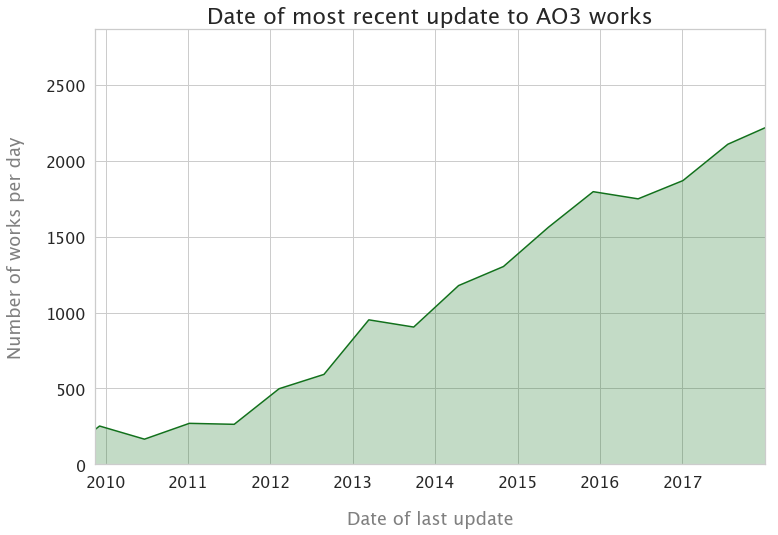

In [4]:
data = db.get_data("Date")
data_date = [d.toordinal() for d in data['Date']]    
fig, ax = plt.subplots()
ax = renorm_kde_plot(data_date, ax, color=single_color)#, bw=15)
desired_xticks = [datetime.date(yr, 1, 1).toordinal() for yr in range(2010, 2018)]
desired_xlim = (datetime.date(2009, 11, 15).toordinal(), datetime.date(2018, 1, 1).toordinal())
ax.set_xlim(desired_xlim)
ax.set_xticks(desired_xticks)
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y') for x in desired_xticks]
ax.set_xticklabels(xlabels)

ax.set_xlabel("Date of last update")
ax.set_ylabel("Number of works per day")
ax.set_title("Date of most recent update to AO3 works")
fig.savefig("all_works_by_date.png")

To get information about monthly variation we need to take out the yearly-increasing trend, so compute the expected number of works per day if linear...

In [5]:
data = data[data['Date']<datetime.date(2018, 1, 1)]
data['Counts'] = np.ones(len(data))
date_grouped = data.groupby('Date')
date_counts = date_grouped.count()
first_day = datetime.date(2009, 11, 15)
day = np.array([(i.date()-first_day).days for i in pd.to_datetime(date_counts.index)])
mask = day>=0
m, c = np.polyfit(day[mask], date_counts['Counts'][mask], 1)
date_counts['Expected counts'] = np.clip((m*day+c), 0, None)
date_counts['Month'] = [x.strftime("%B")[:3] for x in date_counts.index]
date_counts['Day'] = [x.day for x in date_counts.index]
date_counts['day_of_week'] = [x.dayofweek for x in date_counts.index]
# Next two tables: Make a pd.DataFrame with the rows being day of month, columns being month,
# and values being the total number of works posted (or expected)
date_counts_total = date_counts.pivot_table(columns='Month', index='Day', aggfunc='sum', values='Counts')
date_counts_expected = date_counts.pivot_table(columns='Month', index='Day', aggfunc='sum', values='Expected counts')

/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


1062148.1508407667
999439
[2212.92224235 2215.50523053 2218.08821872 2220.6712069  2223.25419508
 2225.83718326 2228.42017144 2231.00315963 2233.58614781 2236.16913599
 2238.75212417 2241.33511235 2243.91810053 2246.50108872 2249.0840769
 2251.66706508 2254.25005326 2256.83304144 2259.41602963 2261.99901781
 2264.58200599 2267.16499417 2269.74798235 2272.33097054 2274.91395872
 2277.4969469  2280.07993508 2282.66292326 2285.24591144 2287.82889963
 2290.41188781 2292.99487599 2295.57786417 2298.16085235 2300.74384054
 2303.32682872 2305.9098169  2308.49280508 2311.07579326 2313.65878145
 2316.24176963 2318.82475781 2321.40774599 2323.99073417 2326.57372235
 2329.15671054 2331.73969872 2334.3226869  2336.90567508 2339.48866326
 2342.07165145 2344.65463963 2347.23762781 2349.82061599 2352.40360417
 2354.98659236 2357.56958054 2360.15256872 2362.7355569  2365.31854508
 2367.90153326 2370.48452145 2373.06750963 2375.65049781 2378.23348599
 2380.81647417 2383.39946236 2385.98245054 2388.5654

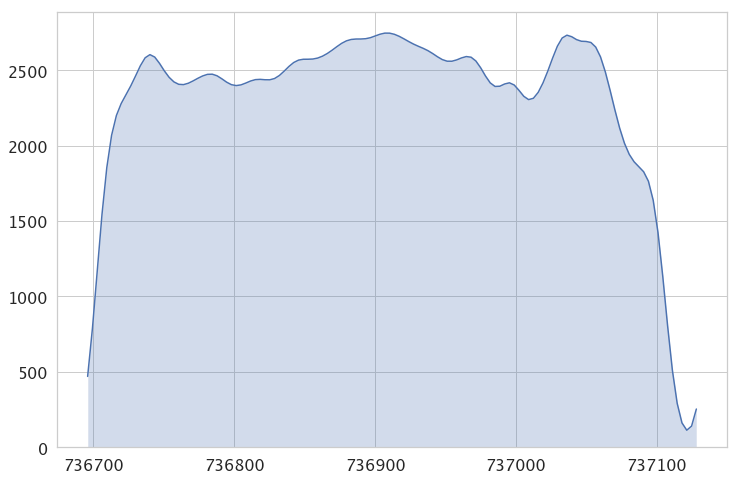

In [12]:
lo = (datetime.date(2018, 1, 1)-first_day).days
hi = (datetime.date(2019, 3, 23)-first_day).days
y_lo = m*lo+c
y_hi = m*hi+c
qdata = db.get_data("ID", "Date", conditions=["Date > '2018-01-01'"])
qdata['OrdinalDate'] = [d.toordinal() for d in qdata['Date']]
print((hi-lo)*y_lo+0.5*(hi-lo)*(y_hi-y_lo))
print(len(qdata))
fig, ax = plt.subplots()
renorm_kde_plot(qdata["OrdinalDate"], ax)
print (m*(new_x-first_day.toordinal())+c)

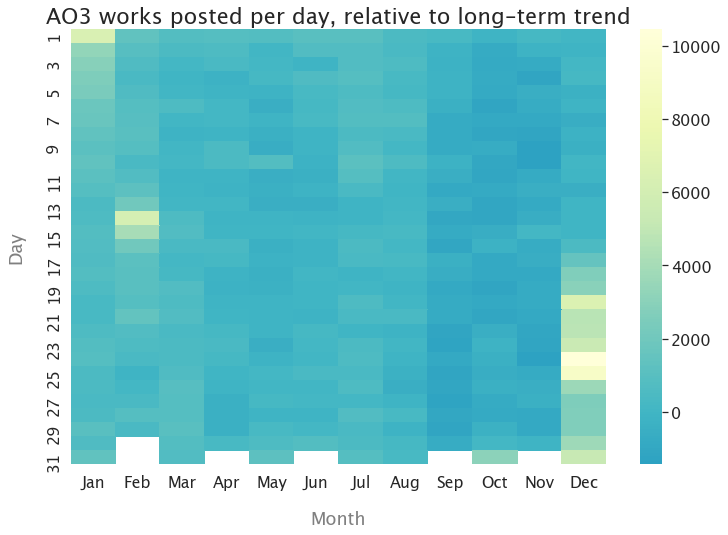

In [7]:
# Make yearly heatmap
heatmap_data = date_counts_total - date_counts_expected
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
heatmap_data = heatmap_data[months]

fig, ax = plt.subplots()
sns.heatmap(heatmap_data, ax=ax, cmap='YlGnBu_r', center=0)
ax.set_title("AO3 works posted per day, relative to long-term trend")
fig.savefig("yearly_heatmap.png")

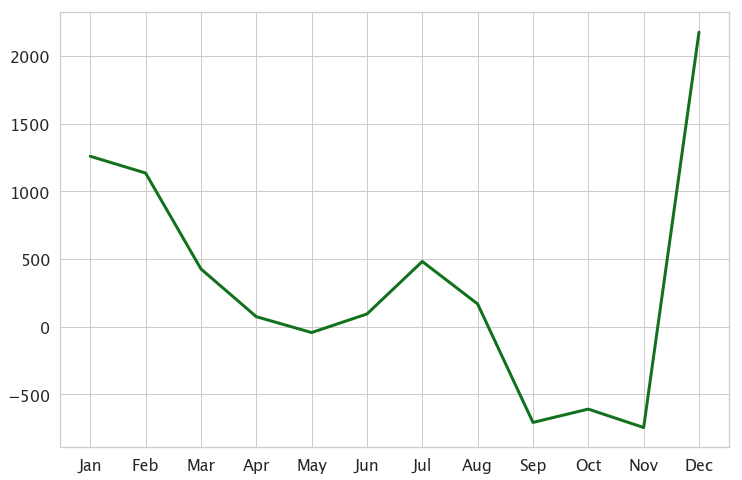

In [8]:
month_avs = []
for month in months:
    month_avs.append(np.mean(heatmap_data[month].dropna()))

fig, ax = plt.subplots()
sns.lineplot(np.arange(12), month_avs, color=single_color, lw=3)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(months)
ax=ax

How about weekly variation?

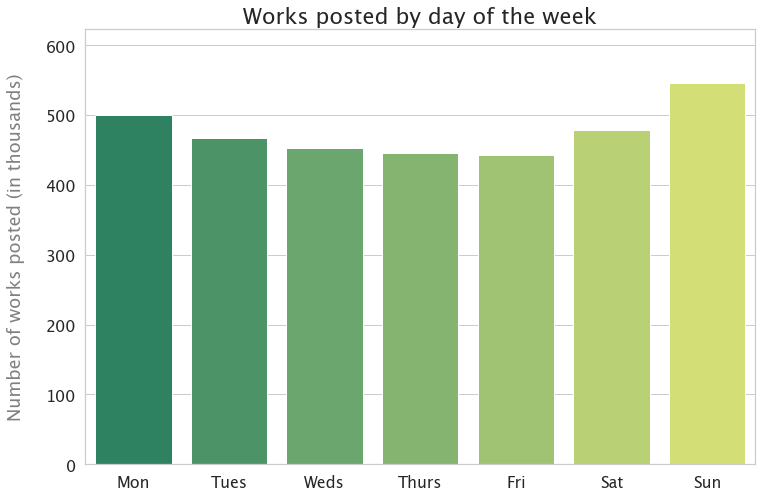

In [9]:
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.barplot(x="day_of_week", y='Counts', estimator=np.sum, data=date_counts, palette='summer', ax=ax, errwidth=0)
ax.set_ylabel("Number of works posted")
ax.set_xticklabels(["Mon", "Tues", "Weds", "Thurs", "Fri", "Sat", "Sun"])
ax.set_xlabel("")
rescale_axis(ax, axis='y', rescale=1000)
ax.set_title("Works posted by day of the week")
fig.savefig("weekly_heatmap.png")

Okay. That's number of works.  How about total hit counts summed over those works?

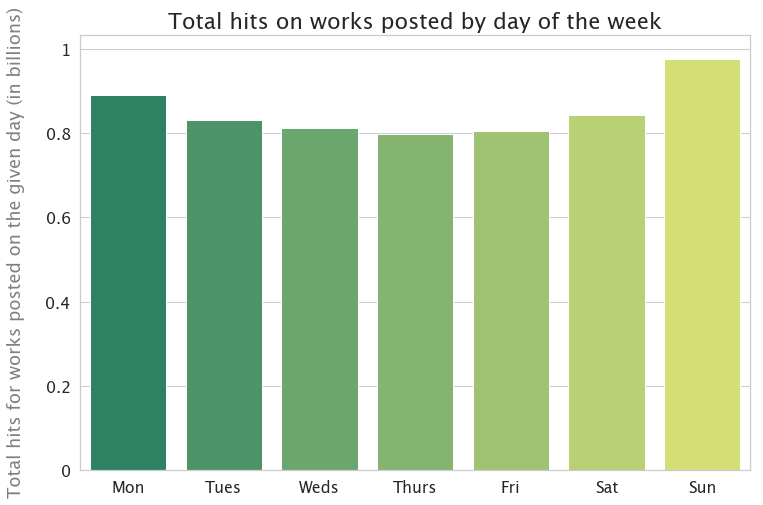

In [10]:
data = db.get_data('Hits', 'Date', conditions=["Hits IS NOT NULL"])
data['day_of_week'] = [x.dayofweek for x in data["Date"]]
fig, ax = plt.subplots()
sns.barplot(x="day_of_week", y="Hits", estimator=np.sum, data=data, ax=ax, palette='summer', errwidth=0)
ax.set_ylabel("Total hits for works posted on the given day")
ax.set_xlabel("")
ax.set_xticklabels(["Mon", "Tues", "Weds", "Thurs", "Fri", "Sat", "Sun"])
rescale_axis(ax, axis='y', rescale=1000000000)
ax.set_title("Total hits on works posted by day of the week")
fig.savefig("weekly_heatmap_hits.png")

How about things tagged as non-fanfic?

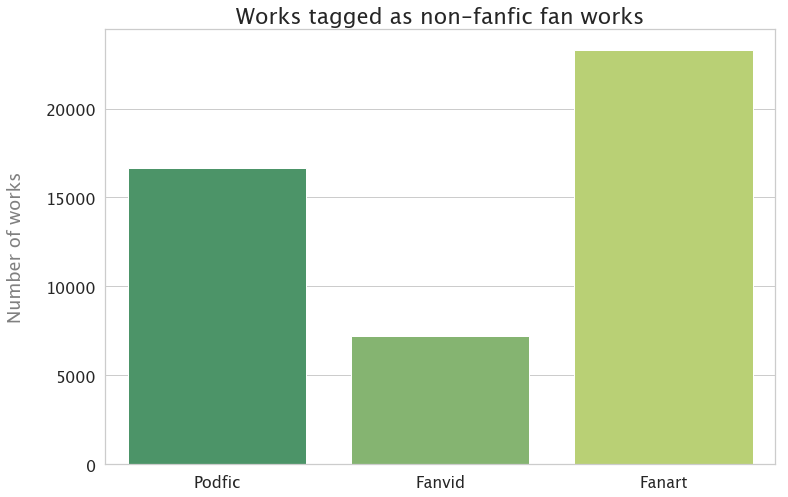

In [11]:
audio_data = db.get_data("TagName", "ID",
                         conditions=["LOWER(TagName) = 'podfic' OR LOWER(TagName) = 'pod\%20fic' "
                                     "OR LOWER(TagName) = 'audiobook' OR LOWER(TagName) = 'audio\%20book'"])
vid_data = db.get_data("TagName", "ID",
                       conditions=["LOWER(TagName) = 'fanvid' OR LOWER(TagName) = 'amv' "
                                   "OR LOWER(TagName) = 'fanvids' OR LOWER(TagName) = '%fandom\%20vid%'"])
art_data = db.get_data("TagName", "ID",
                       conditions=["LOWER(TagName) = 'art' OR LOWER(TagName) = 'fanart' "
                                   "OR LOWER(TagName) = 'fan\%20art'"])
audio_data = audio_data.drop_duplicates(subset="ID")
vid_data = vid_data.drop_duplicates(subset="ID")
art_data = art_data.drop_duplicates(subset="ID")
data = ["Podfic"]*len(audio_data) + ["Fanvid"]*len(vid_data) + ["Fanart"]*len(art_data)

fig, ax = plt.subplots()
sns.countplot(data, ax=ax, palette='summer')
plt.ylabel("Number of works")
ax.set_title("Works tagged as non-fanfic fan works")
plt.savefig("audio_video_art.png")

Works in different languages...

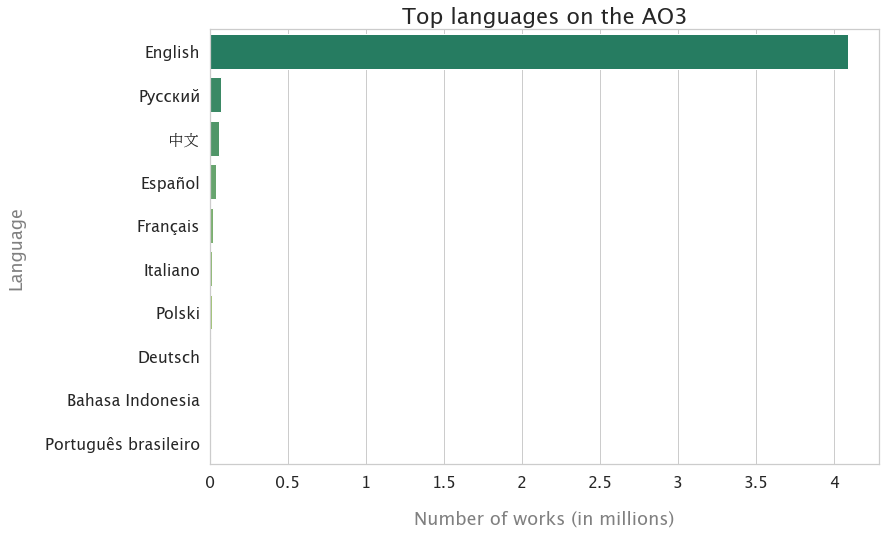

In [12]:
data = db.get_data("Language").dropna()
top_langs = data["Language"].value_counts()[:10]
data = data[data["Language"].isin(top_langs.index)]
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.countplot(y="Language", data=data, ax=ax, order=top_langs.index, palette='summer')
ax.set_xlabel("Number of works")
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=90, horizontalalignment='right')

labels = ax.get_yticklabels()
labels[2].set_fontname('IPAMincho')
labels[2] = u'中文'
ax.set_yticklabels(labels)
ax.set_title("Top languages on the AO3")
rescale_axis(ax, axis='x', rescale=1000000)
fig.savefig("language_barplot.png")

How many things are there with the different ratings?

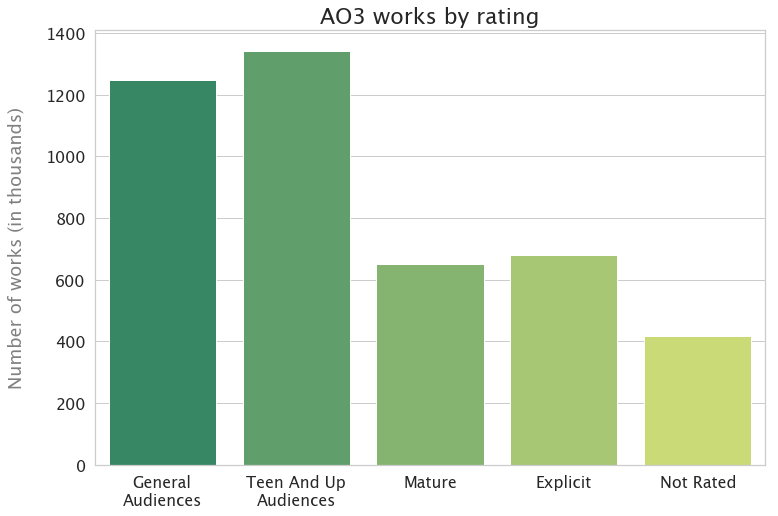

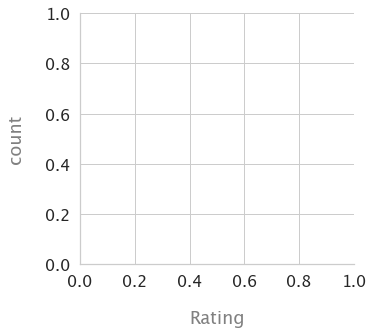

In [13]:
data = db.get_data('Rating')
# For some unknown reason, one (1) work in my database has this rating. I don't know either.
data.loc[data['Rating']=="Teen And Up Audiences, Not Rated", 'Rating'] = u"Teen And Up Audiences"
# "No rating" is basically NaN, a processing failure.
data = data.query('Rating != "No rating"')

fig, ax = plt.subplots()#gridspec_kw={"left": 0.3, 'bottom': 0.3})
labels = [u'General Audiences', u'Teen And Up Audiences', u'Mature', u'Explicit', u'Not Rated']
sns.catplot(x="Rating", kind="count", data=data, order=labels, ax=ax, palette='summer') 
ax.set_ylabel("Number of works")
ax.set_xticklabels(["General\nAudiences", "Teen And Up\nAudiences", "Mature", "Explicit", "Not Rated"])
ax.set_xlabel("")
ax.set_title("AO3 works by rating")
rescale_axis(ax, axis='y', rescale=1000)
fig.savefig("ratings_histogram.png")

How about different pairing types?

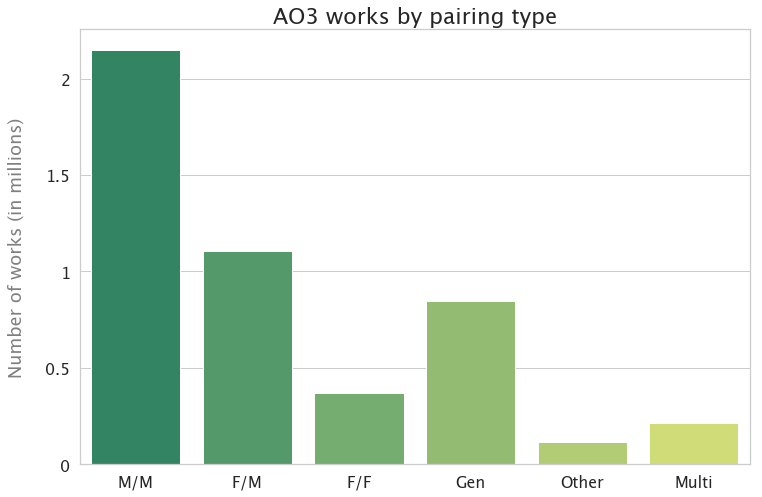

In [14]:
data = db.get_data('PairingType')
data = data.query("PairingType != 'No category'") # 'No category' is NULL for this column
pairing_types = ['M/M', 'F/M', 'F/F', 'Gen', 'Other', 'Multi']
# The "PairingType" column is a comma-separated list of the pairing types
# portrayed in the work.
# These next lines make a list of the different text slugs in pairing_types,
# with the number of repeats given by the number of rows in data containing
# that pairing type.
pairing_data = []
for pt in pairing_types:
    pairing_data += [pt]*np.sum(data['PairingType'].str.contains(pt))

fig, ax = plt.subplots()
sns.countplot(pairing_data, ax=ax, palette='summer')
ax.set_ylabel("Number of works")
rescale_axis(ax, axis='y', rescale=1000000)
ax.set_title("AO3 works by pairing type")
fig.savefig("pairingtype_histogram.png")

Complete vs incomplete works?

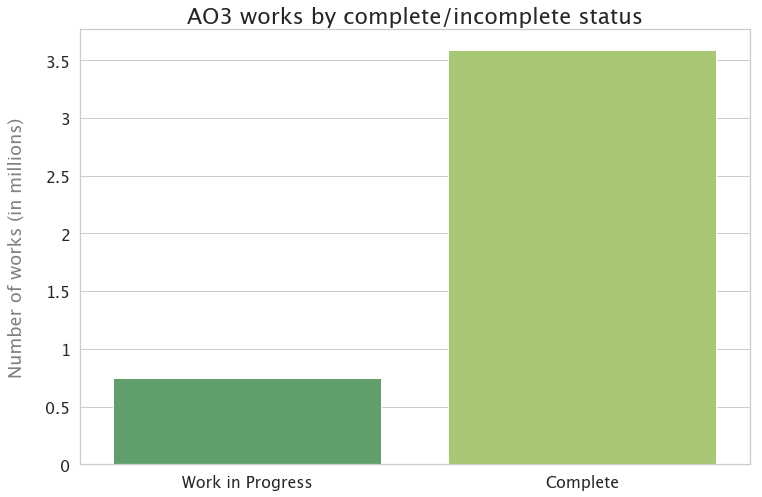

In [15]:
data = db.get_data("Complete")
fig, ax = plt.subplots()
sns.countplot(data["Complete"], ax=ax, palette='summer')
ax.set_xticklabels(["Work in Progress", "Complete"])
plt.ylabel("Number of works")
plt.xlabel("")
ax.set_title("AO3 works by complete/incomplete status")
rescale_axis(ax, axis='y', rescale=1000000)
plt.savefig("complete_barchart.png")

Is that different over the last year, since in earlier years those works may have been completed already?

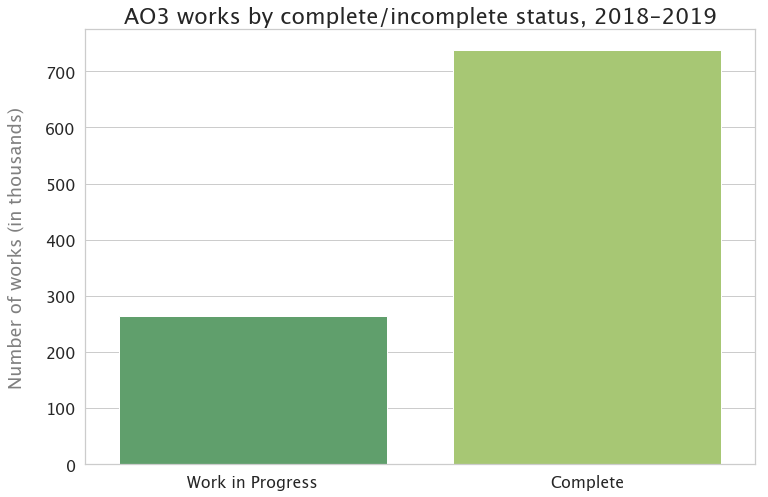

In [16]:
data = db.get_data("Complete", conditions=["Date between '2018-01-01' and '2019-12-31'"])
fig, ax = plt.subplots()
sns.countplot(data["Complete"], ax=ax, palette='summer')
ax.set_xticklabels(["Work in Progress", "Complete"])
plt.ylabel("Number of works")
plt.xlabel("")
ax.set_title("AO3 works by complete/incomplete status, 2018-2019")
rescale_axis(ax, axis='y', rescale=1000)
plt.savefig("complete_barchart_lastyear.png")

Hmm--what's the trend with WsiP over time?

Okay. Now let's look at work length.  What's the distribution of word counts?

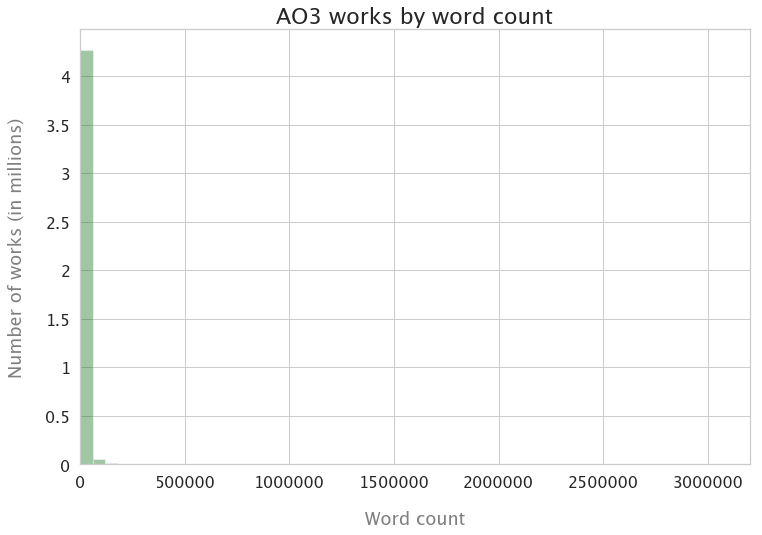

In [18]:
data = db.get_data("Words").replace('', 0)
fig, ax = plt.subplots(figsize=figsize)
sns.distplot(data["Words"], kde=False, ax=ax, color=single_color)
ax.set_xlim((0, ax.get_xlim()[1]))
ax.set_xlabel("Word count")
ax.set_ylabel("Number of works")
ax.set_title("AO3 works by word count")
rescale_axis(ax, axis='y', rescale=1000000)
fig.savefig("wordcount.png")

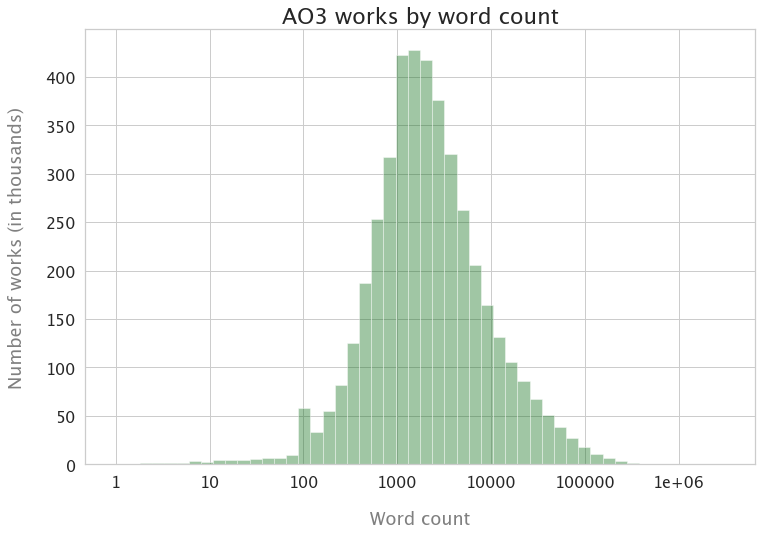

In [19]:
fig, ax = plt.subplots(figsize=figsize)
sns.distplot(np.log10(data["Words"][data['Words']>0]).dropna(), kde=False, ax=ax, color=single_color)
add_log_axis_labels(ax)
ax.set_xlabel("Word count")
ax.set_ylabel("Number of works")
ax.set_title("AO3 works by word count")
rescale_axis(ax, axis='y', rescale=1000)
fig.savefig("wordcount_log.png")

And how are those divided into chapters?  Do some bar charts for better investigation (both including all works, or limiting ourselves to incomplete works), then a KDE plot for fun that goes out to the maximum number of chapters.

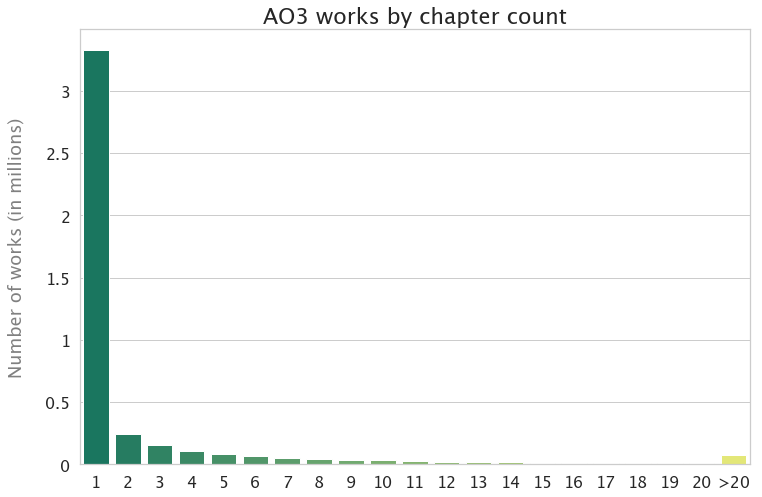

In [15]:
fig, ax = plt.subplots()
data = db.get_data("Chapters").fillna(-1).clip(upper=21, lower=1)
data["Chapters"] = data["Chapters"].map(int)
sns.countplot(x="Chapters", data=data, ax=ax, palette='summer')
ax.set_ylabel("Number of works")
xticks = ax.get_xticklabels()
xticks[-1] = ">20"
ax.set_xticklabels(xticks)
ax.set_xlabel("")
ax.set_title("AO3 works by chapter count")
rescale_axis(ax, axis='y', rescale=1000000)
fig.savefig("total_chapter_counts.png")

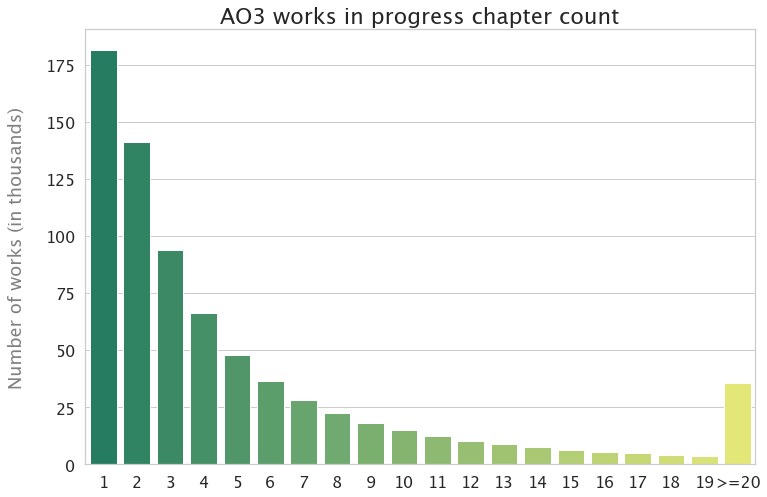

In [21]:
fig, ax = plt.subplots()
data = db.get_data("Chapters", conditions=["Complete = 0"]).clip(upper=20)
sns.countplot(x="Chapters", data=data, ax=ax, palette='summer')
ax.set_ylabel("Number of works")
xticks = ax.get_xticklabels()
#xticks[0] = "?"
xticks[-1] = ">=20"
ax.set_xticklabels(xticks)
ax.set_xlabel("")
ax.set_xlim((0.45, ax.get_xlim()[1]))
ax.set_title("AO3 works in progress chapter count")
rescale_axis(ax, axis='y', rescale=1000)
fig.savefig("chapter_counts_incomplete.png")

In [17]:
def two_sig_fig(x):
    pow10 = np.floor(np.nan_to_num(np.log10(x)))
    return 10**(pow10)*np.floor(x/10**(pow10))

/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


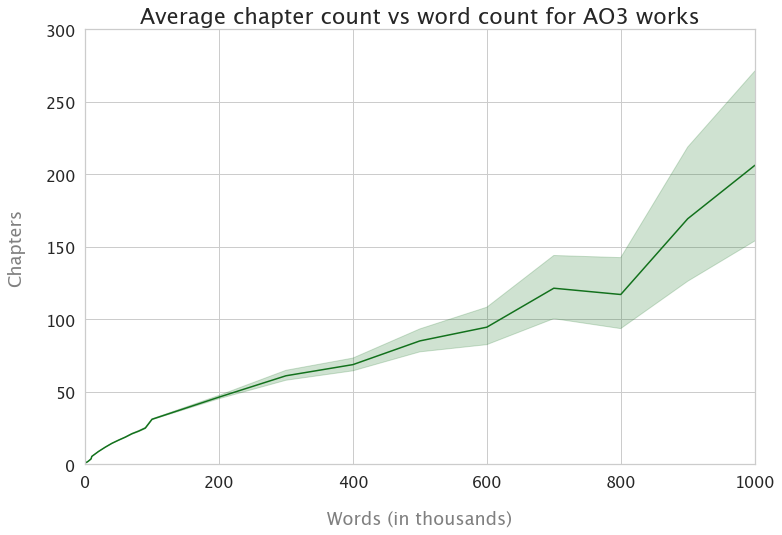

In [19]:
data = db.get_data("Chapters", "Words").replace('', 0)
fig, ax = plt.subplots()
sns.lineplot(x=two_sig_fig(data["Words"]), y=data["Chapters"], ax=ax, color=single_color)
ax.set_xlim(0, 1000000)
ax.set_ylim(0, 300)
ax.set_title("Average chapter count vs word count for AO3 works")
rescale_axis(ax, axis='x', rescale=1000)
fig.savefig("chapters_v_words.png")

Some info on series...

In [24]:
data = db.get_data("ID")
series_id = db.get_data("ID", "SeriesID")
data["Series"] = data.index.isin(series_id.index)
print("Number in series:", np.sum(data["Series"]))
print("Number not in series:", len(data)-np.sum(data["Series"]))

Number in series: 1036680
Number not in series: 3300865


Now, reader engagement metrics: hits, kudos, comments, and bookmarks.

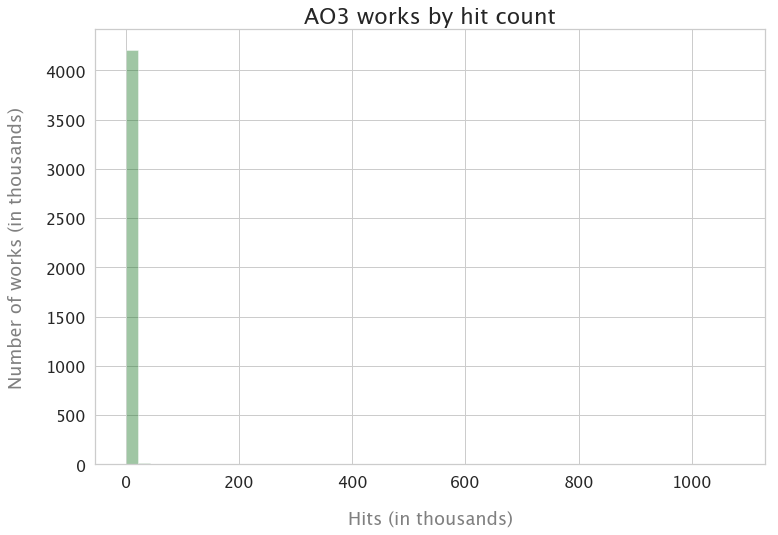

In [25]:
data = db.get_data("Hits")

fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.distplot(data['Hits'].dropna(), kde=False, ax=ax, color=single_color)
ax.set_ylabel("Number of works")
ax.set_title("AO3 works by hit count")
rescale_axis(ax, rescale=1000)
rescale_axis(ax, rescale=1000, axis='y')
fig.savefig("hits_histogram.png")

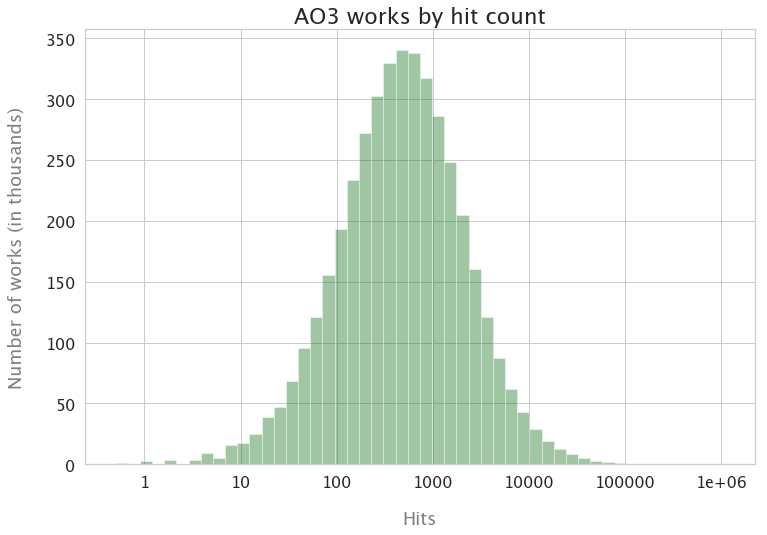

In [26]:
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.distplot(np.log10(data['Hits'].clip(lower=0.5)).dropna(), kde=False, ax=ax, color=single_color)
ax.set_ylabel("Number of works")
add_log_axis_labels(ax)
ax.set_title("AO3 works by hit count")
rescale_axis(ax, rescale=1000, axis='y')
fig.savefig("hits_histogram_log.png")

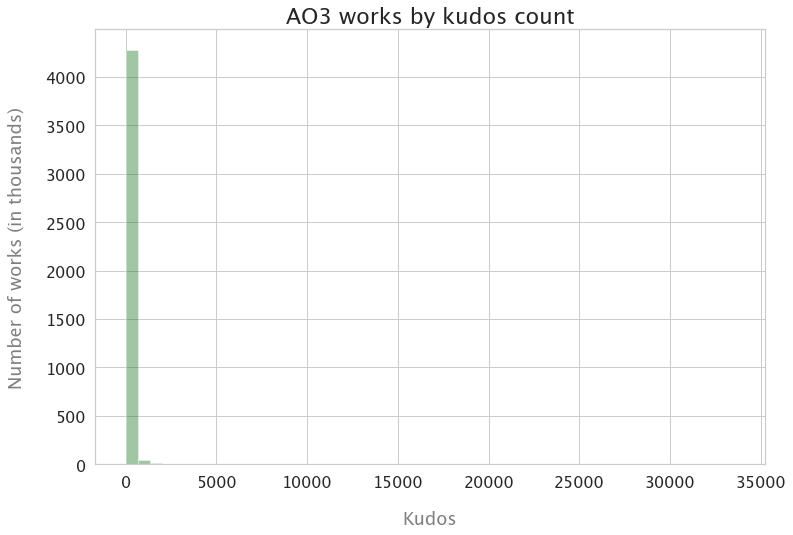

In [27]:
data = db.get_data('Kudos').dropna()
data = data.loc[~(data['Kudos'].str.contains('<').fillna(False))] #processing error on <20 items

# Histogram of numbers of kudos
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.distplot(data["Kudos"].map(int), kde=False, ax=ax, color=single_color)
ax.set_ylabel("Number of works")
ax.set_title("AO3 works by kudos count")
rescale_axis(ax, rescale=1000, axis='y')
fig.savefig("kudos_histogram.png")

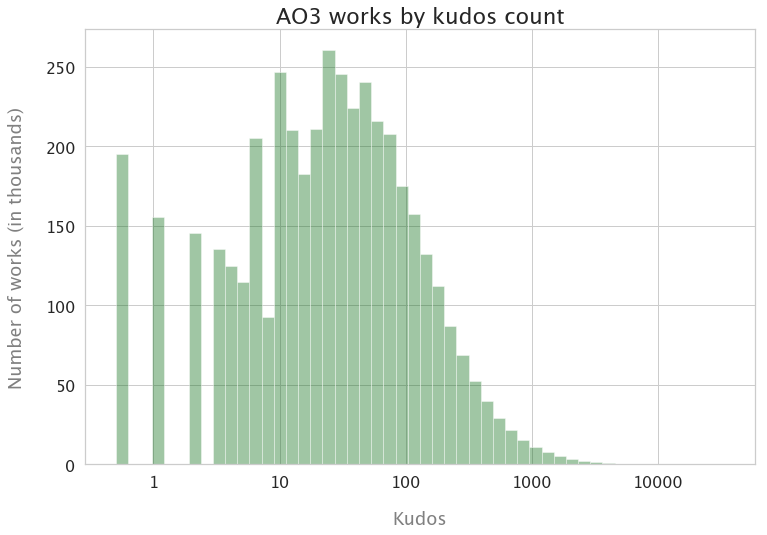

In [28]:
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.distplot(np.log10(data["Kudos"].map(float).clip(lower=0.5)), kde=False, ax=ax, color=single_color)
ax.set_ylabel("Number of works")
add_log_axis_labels(ax)
rescale_axis(ax, rescale=1000, axis='y')
ax.set_title("AO3 works by kudos count")
fig.savefig("kudos_histogram_log.png")

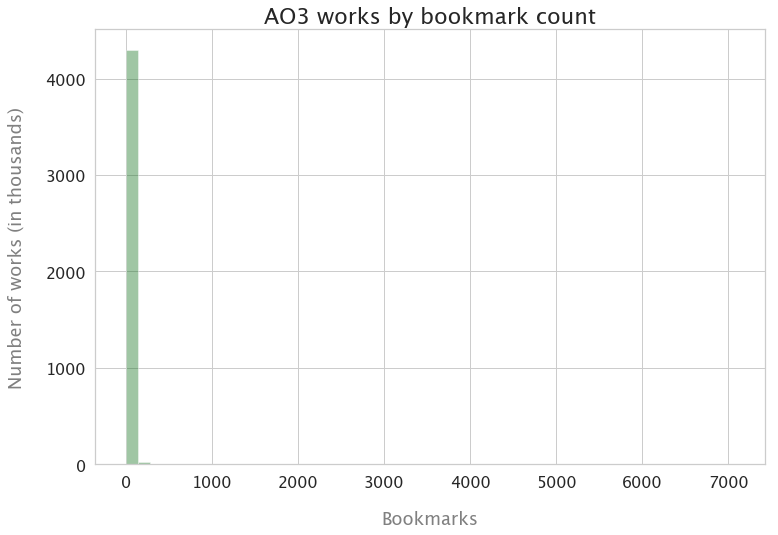

In [29]:
data = db.get_data('Bookmarks')
data = data.loc[~(data['Bookmarks'].str.contains('<').fillna(False))]

# Histogram of numbers of bookmarks
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.distplot(data["Bookmarks"].map(int), kde=False, ax=ax, color=single_color)
ax.set_ylabel("Number of works")
rescale_axis(ax, rescale=1000, axis='y')
ax.set_title("AO3 works by bookmark count")
fig.savefig("bookmarks_histogram.png")

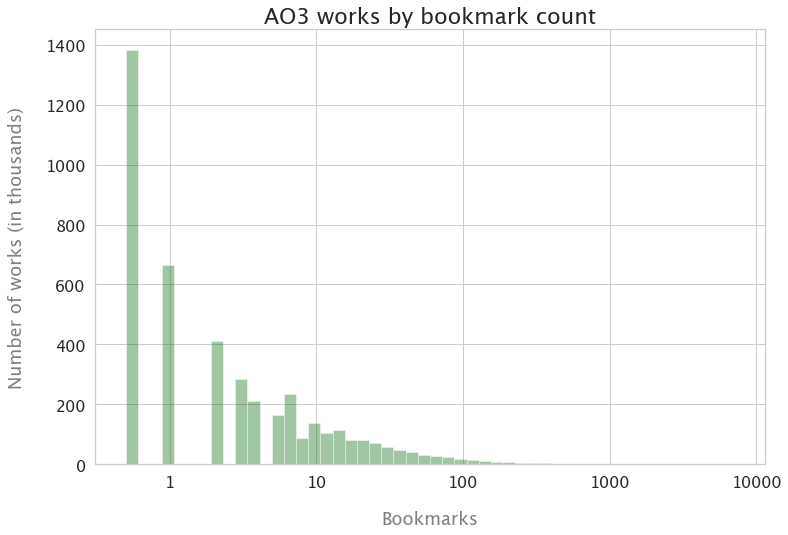

In [30]:
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.distplot(np.log10(data["Bookmarks"].map(float).clip(lower=0.5)), kde=False, ax=ax, color=single_color)
ax.set_ylabel("Number of works")
add_log_axis_labels(ax)
rescale_axis(ax, rescale=1000, axis='y')
ax.set_title("AO3 works by bookmark count")
fig.savefig("bookmarks_histogram.png")

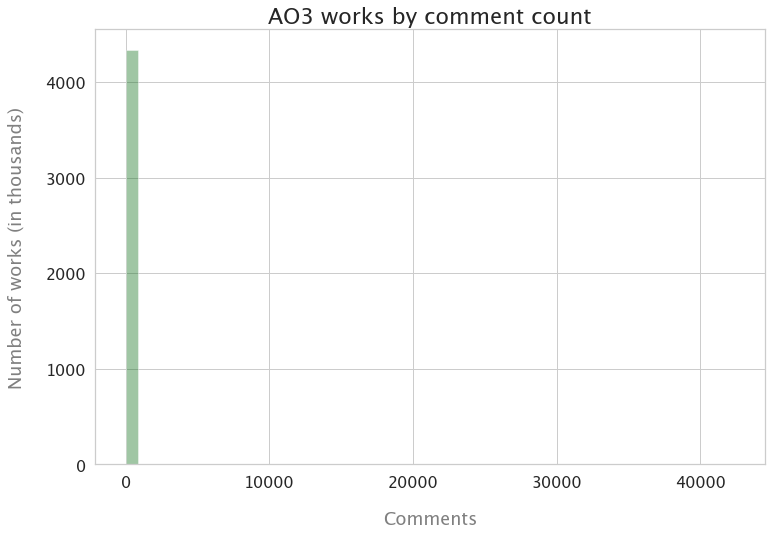

In [31]:
data = db.get_data('Comments')
data = data.loc[~(data['Comments'].str.contains('<').fillna(False))]

# Histogram of numbers of comments
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.distplot(data["Comments"].map(int), kde=False, ax=ax, color=single_color)
ax.set_ylabel("Number of works")
rescale_axis(ax, rescale=1000, axis='y')
ax.set_title("AO3 works by comment count")
fig.savefig("comments_histogram.png")

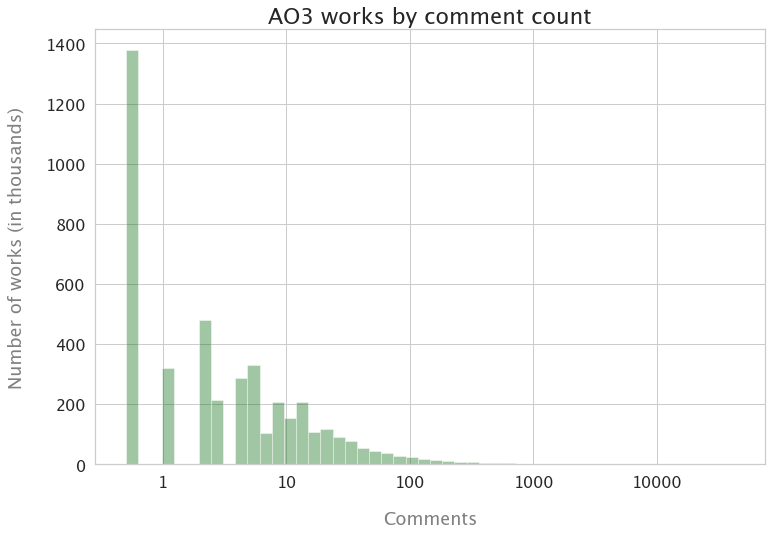

In [32]:
# Histogram of numbers of comments
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.distplot(np.log10(data["Comments"].map(float).clip(lower=0.5)), kde=False, ax=ax, color=single_color)
ax.set_ylabel("Number of works")#, labelpad=20)
#ax.set_xlabel(ax.get_xlabel(), labelpad=20)
add_log_axis_labels(ax)
rescale_axis(ax, rescale=1000, axis='y')
ax.set_title("AO3 works by comment count")
fig.savefig("comments_histogram.png")